# Toy Problems from the Book of Why & Causality

I originally learned about Causal Graphs from the *Book of Why*, so I was naturaly interested in testing out DoWhy on examples from that book. 

In [2]:
import pandas as pd
import numpy as np
import daft
import dowhy
from dowhy.do_why import CausalModel
import statsmodels.api as sm

## Example 1: Book of Why Backdoor Games

These games all come from Chapter 4 of the Book of Why.  They are devoid of context, but the graphical model is given and our only job is to identify the set of backdoor paths from X to Y.  I will use these games as unit tests of the behavior of DoWhy's backdoor algorithm.

### Game 1

This relatively trivial game has no backdoor paths. 

Error: Pygraphviz cannot be loaded. module 'pygraphviz' has no attribute 'AGraph'
Trying pydot ...
[]
Model to find the causal effect of treatment X on outcome Y
Using Matplotlib for plotting


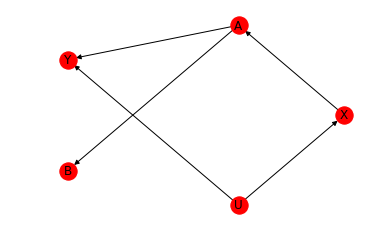

In [2]:
graph_dot = "digraph {X -> A;A -> Y;A -> B;}"

data = pd.DataFrame({var: np.random.choice(2, 100) for var in ['X', 'A', 'Y', 'B']})

game_one = CausalModel(
                data=data,
                treatment='X',
                outcome='Y',
                graph=graph_dot)

game_one.view_model()

In [3]:
identified_estimand = game_one.identify_effect()
print(identified_estimand)

INFO:dowhy.causal_identifier:Common causes of treatment and outcome:{'U'}


{'label': 'Unobserved Confounders', 'observed': 'no'}
There are unobserved common causes. Causal effect cannot be identified.


WARN: Do you want to continue by ignoring these unobserved confounders? [y/n]  y


INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:[]


Estimand type: ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
d                  
──(Expectation(Y|))
dX                 
Estimand assumption 1, Unconfoundedness: If U→X and U→Y then P(Y|X,,U) = P(Y|X,)
### Estimand : 2
Estimand name: iv
No such variable found!



In [50]:
# Unfortunate that this generates an error.  
lr_estimate = game_one.estimate_effect(identified_estimand,
        method_name="backdoor.propensity_score_stratification")
print(lr_estimate)
print("Causal Estimate is " + str(lr_estimate.value))

PropensityScoreStratificationEstimator


ValueError: No objects to concatenate

In [4]:
# We can confirm this estimate against what we could produce without DoWhy
lm = sm.OLS(endog=data['Y'], exog=sm.tools.add_constant(data['X']))
res = lm.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.010
Method:                 Least Squares   F-statistic:                     0.000
Date:                Thu, 14 Mar 2019   Prob (F-statistic):               1.00
Time:                        10:59:54   Log-Likelihood:                -72.579
No. Observations:                 100   AIC:                             149.2
Df Residuals:                      98   BIC:                             154.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5000      0.071      7.000      0.0

### Game 2
Introduces a backdoor path, but it's already blocked!

Error: Pygraphviz cannot be loaded. module 'pygraphviz' has no attribute 'AGraph'
Trying pydot ...
['A']
yes
{'observed': 'yes'}
Model to find the causal effect of treatment X on outcome Y
Using Matplotlib for plotting


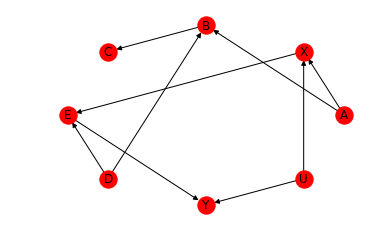

In [5]:
graph_dot = "digraph {A -> X;A -> B;B -> C;X -> E;D -> B;D -> E;E -> Y}"

data = pd.DataFrame({var: np.random.choice(2, 100) for var in ['X', 'A', 'Y', 'B', 'C', 'D', 'E']})

game_two = CausalModel(
                data=data,
                treatment='X',
                outcome='Y',
                graph=graph_dot)

game_two.view_model()

In [6]:
identified_estimand = game_two.identify_effect()
print(identified_estimand)

INFO:dowhy.causal_identifier:Common causes of treatment and outcome:{'A', 'U'}


{'observed': 'yes'}
{'label': 'Unobserved Confounders', 'observed': 'no'}
There are unobserved common causes. Causal effect cannot be identified.


WARN: Do you want to continue by ignoring these unobserved confounders? [y/n]  y


INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:['A']


Estimand type: ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
d                   
──(Expectation(Y|A))
dX                  
Estimand assumption 1, Unconfoundedness: If U→X and U→Y then P(Y|X,A,U) = P(Y|X,A)
### Estimand : 2
Estimand name: iv
Estimand expression:
Expectation(Derivative(Y, A)/Derivative(X, A))
Estimand assumption 1, As-if-random: If U→→Y then ¬(U →→A)
Estimand assumption 2, Exclusion: If we remove {A}→X, then ¬(A→Y)



In [7]:
lr_estimate = game_two.estimate_effect(identified_estimand,
        method_name="backdoor.linear_regression")
print(lr_estimate)
print("Causal Estimate is " + str(lr_estimate.value))

LinearRegressionEstimator


INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Y~X+A


*** Causal Estimate ***

## Target estimand
Estimand type: ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
d                   
──(Expectation(Y|A))
dX                  
Estimand assumption 1, Unconfoundedness: If U→X and U→Y then P(Y|X,A,U) = P(Y|X,A)
### Estimand : 2
Estimand name: iv
Estimand expression:
Expectation(Derivative(Y, A)/Derivative(X, A))
Estimand assumption 1, As-if-random: If U→→Y then ¬(U →→A)
Estimand assumption 2, Exclusion: If we remove {A}→X, then ¬(A→Y)

## Realized estimand
b: Y~X+A
## Estimate
Value: -0.03787984388068028

Causal Estimate is -0.03787984388068028


The identified estimand, $Y \sim X+A$, is again not what we expect.  It is treating A as an instrumental variable... I'm not sure that this is totally correct, though the back door paths from A to Y are blocked and thus we aren't actually introducing bias by controlling for A.  However, since the only backdoor path from X to Y is blocked by the collider at B we don't need to control for A in the first place, which was the answer that I expected from the algorithm.

In [8]:
# We can confirm this estimate against what we could produce without DoWhy
lm = sm.OLS(endog=data['Y'], exog=sm.tools.add_constant(data[['X']]))
res = lm.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.009
Method:                 Least Squares   F-statistic:                    0.1354
Date:                Thu, 14 Mar 2019   Prob (F-statistic):              0.714
Time:                        11:00:44   Log-Likelihood:                -71.213
No. Observations:                 100   AIC:                             146.4
Df Residuals:                      98   BIC:                             151.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5938      0.062      9.534      0.0

### Game 3

This game finally introduces a backdoor path which requires us to control for a variable.

Error: Pygraphviz cannot be loaded. module 'pygraphviz' has no attribute 'AGraph'
Trying pydot ...
['B']
yes
{'observed': 'yes'}
Model to find the causal effect of treatment X on outcome Y
Using Matplotlib for plotting


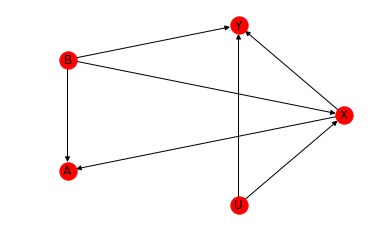

In [9]:
graph_dot = "digraph {X -> Y;B -> X;B -> Y;X -> A;B -> A;}"

data = pd.DataFrame({var: np.random.choice(2, 100) for var in ['X', 'A', 'Y', 'B']})

game_three = CausalModel(
                data=data,
                treatment='X',
                outcome='Y',
                graph=graph_dot)

game_three.view_model()

In [10]:
identified_estimand = game_three.identify_effect()
print(identified_estimand)

INFO:dowhy.causal_identifier:Common causes of treatment and outcome:{'B', 'U'}


{'observed': 'yes'}
{'label': 'Unobserved Confounders', 'observed': 'no'}
There are unobserved common causes. Causal effect cannot be identified.


WARN: Do you want to continue by ignoring these unobserved confounders? [y/n]  y


INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:[]


Estimand type: ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
d                   
──(Expectation(Y|B))
dX                  
Estimand assumption 1, Unconfoundedness: If U→X and U→Y then P(Y|X,B,U) = P(Y|X,B)
### Estimand : 2
Estimand name: iv
No such variable found!



In [11]:
lr_estimate = game_three.estimate_effect(identified_estimand,
        method_name="backdoor.linear_regression")
print(lr_estimate)
print("Causal Estimate is " + str(lr_estimate.value))

INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Y~X+B


LinearRegressionEstimator
*** Causal Estimate ***

## Target estimand
Estimand type: ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
d                   
──(Expectation(Y|B))
dX                  
Estimand assumption 1, Unconfoundedness: If U→X and U→Y then P(Y|X,B,U) = P(Y|X,B)
### Estimand : 2
Estimand name: iv
No such variable found!

## Realized estimand
b: Y~X+B
## Estimate
Value: -0.12643358587613818

Causal Estimate is -0.12643358587613818


This one worked great.  Appropriately controls for B. 

### Game 4

This graph is designed specifically as a trap called "M-bias".  Many statisticians would control for B.  What would DoWhy do?

Error: Pygraphviz cannot be loaded. module 'pygraphviz' has no attribute 'AGraph'
Trying pydot ...
[]
Model to find the causal effect of treatment X on outcome Y
Using Matplotlib for plotting


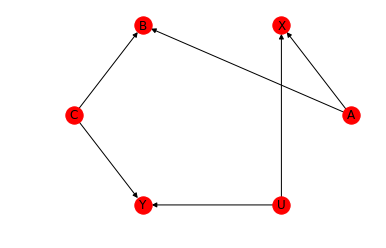

In [12]:
graph_dot = "digraph {A -> X;A -> B;C -> B;C -> Y;}"

data = pd.DataFrame({var: np.random.choice(2, 100) for var in ['X', 'A', 'Y', 'B', 'C']})

game_four = CausalModel(
                data=data,
                treatment='X',
                outcome='Y',
                graph=graph_dot)

game_four.view_model()

In [13]:
identified_estimand = game_four.identify_effect()
print(identified_estimand)

INFO:dowhy.causal_identifier:Common causes of treatment and outcome:{'U'}


{'label': 'Unobserved Confounders', 'observed': 'no'}
There are unobserved common causes. Causal effect cannot be identified.


WARN: Do you want to continue by ignoring these unobserved confounders? [y/n]  y


INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:['A']


Estimand type: ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
d                  
──(Expectation(Y|))
dX                 
Estimand assumption 1, Unconfoundedness: If U→X and U→Y then P(Y|X,,U) = P(Y|X,)
### Estimand : 2
Estimand name: iv
Estimand expression:
Expectation(Derivative(Y, A)/Derivative(X, A))
Estimand assumption 1, As-if-random: If U→→Y then ¬(U →→A)
Estimand assumption 2, Exclusion: If we remove {A}→X, then ¬(A→Y)



In [73]:
lr_estimate = game_four.estimate_effect(identified_estimand,
        method_name="backdoor.linear_regression")
print(lr_estimate)
print("Causal Estimate is " + str(lr_estimate.value))

LinearRegressionEstimator


ValueError: No objects to concatenate

In [14]:
# We can confirm this estimate against what we could produce without DoWhy
lm = sm.OLS(endog=data['Y'], exog=sm.tools.add_constant(data[['X']]))
res = lm.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.009
Method:                 Least Squares   F-statistic:                    0.1340
Date:                Thu, 14 Mar 2019   Prob (F-statistic):              0.715
Time:                        11:01:57   Log-Likelihood:                -72.431
No. Observations:                 100   AIC:                             148.9
Df Residuals:                      98   BIC:                             154.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5000      0.074      6.724      0.0

  

### Game 5

Our final, and most challenging game.  There are two possible solutions, either C alone can be closed or A and B. Let's see what it determines. 

Error: Pygraphviz cannot be loaded. module 'pygraphviz' has no attribute 'AGraph'
Trying pydot ...
['A', 'C', 'B']
yes
{'observed': 'yes'}
yes
{'observed': 'yes'}
yes
{'observed': 'yes'}
Model to find the causal effect of treatment X on outcome Y
Using Matplotlib for plotting


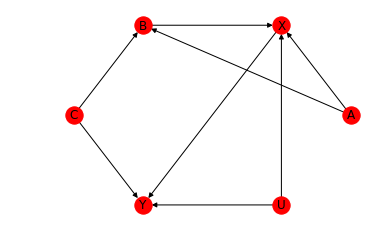

In [15]:
graph_dot = "digraph {A -> X;A -> B;C -> B;C -> Y;B -> X; X -> Y}"

data = pd.DataFrame({var: np.random.choice(2, 100) for var in ['X', 'A', 'Y', 'B', 'C']})

game_five = CausalModel(
                data=data,
                treatment='X',
                outcome='Y',
                graph=graph_dot)

game_five.view_model()

In [16]:
identified_estimand = game_five.identify_effect()
print(identified_estimand)

INFO:dowhy.causal_identifier:Common causes of treatment and outcome:{'A', 'C', 'B', 'U'}


{'observed': 'yes'}
{'observed': 'yes'}
{'observed': 'yes'}
{'label': 'Unobserved Confounders', 'observed': 'no'}
There are unobserved common causes. Causal effect cannot be identified.


WARN: Do you want to continue by ignoring these unobserved confounders? [y/n]  y


INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:['A']


Estimand type: ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
d                       
──(Expectation(Y|A,C,B))
dX                      
Estimand assumption 1, Unconfoundedness: If U→X and U→Y then P(Y|X,A,C,B,U) = P(Y|X,A,C,B)
### Estimand : 2
Estimand name: iv
Estimand expression:
Expectation(Derivative(Y, A)/Derivative(X, A))
Estimand assumption 1, As-if-random: If U→→Y then ¬(U →→A)
Estimand assumption 2, Exclusion: If we remove {A}→X, then ¬(A→Y)



It gives a correct answer, but not nearly the best.  Controlling for C would have been minimally sufficient, and A + B would have been a second best.  It makes me wonder about the logic internally, and why it doesn't aim towards the simplest solutions.  I would like to update the implementation, good practice in anticipation of the front door adjustment.  I have already played with an algorithm that more or less matches what was outlined [in this presentation](https://www.ssc.wisc.edu/~felwert/causality/wp-content/uploads/2013/06/2-elwert_dags.pdf).  For the complete identifcation algorithm we look to the [Ph.D. thesis of Ilya Shpitser](https://ftp.cs.ucla.edu/pub/stat_ser/shpitser-thesis.pdf), which provides a complete algorithm for identifying of a causal estimate can be identified.  Studying it will probably be helpful, particular if we want to be able to include the front-door in our estimands. 